In [1]:
import os
import gc
import glob
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from PIL import Image
import seaborn as sns
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision import utils

import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve, auc

import sys
sys.path.append('../input/timm-pytorch-image-models/pytorch-image-models-master')
import timm

np.random.seed(7)
torch.manual_seed(7)

device='cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [2]:
class CustomDataset(Dataset):
    def __init__(self, root_dir, transform = None):
        root_list = glob.glob(root_dir)
        self.class_map = {}
        self.class_distribution = {}
        self.transform = transform

        for img_path in root_list:
            class_name = img_path.split(os.sep)[-2]
            if class_name not in self.class_distribution:
                self.class_distribution[class_name] = 1
            else:
                self.class_distribution[class_name] +=1

        for index, entity in enumerate(self.class_distribution):
            self.class_map[entity] = index
        print("Dataset Distribution:\n")
        print(self.class_distribution)
        print("\n\nClass indices:\n")
        print(self.class_map)

        self.data = []
        for img_path in tqdm(root_list):
            class_name = img_path.split(os.sep)[-2]
            self.data.append([img_path, class_name])
            
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        img_path, class_name = self.data[idx]
        img = np.load(img_path, allow_pickle = True)
        if class_name == 'axion':
            img = img[0]
        
#         img = np.expand_dims(img, axis = 0)
        
        if self.transform:
            aug = self.transform(image=img)
            img = aug['image']
        
        img = img.to(torch.float)
        class_id = self.class_map[class_name]
        class_id = torch.tensor(class_id)
        
        if img.shape != (1, 50, 50):
            print("DIMENSIONAL ERROR")

        return img, class_id

In [3]:
transforms = A.Compose(
            [
                A.CenterCrop(height = 50, width = 50, p=1.0),
                ToTensorV2()
            ]
        )

In [4]:
BS = 128

In [5]:
data_path = r'../input/gsocml4scimodel2/Model_II/*/*'
dataset = CustomDataset(data_path, transform = transforms)

Dataset Distribution:

{'axion': 29896, 'no_sub': 29449, 'cdm': 29759}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/89104 [00:00<?, ?it/s]

In [6]:
m = len(dataset)
test_split_size = 0.1

print("Total training data: " + str(m))

try:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size)])
except:
    train_set,val_set=random_split(dataset,[int(m-m*test_split_size),int(m*test_split_size+1)])
    
len(train_set), len(val_set)

Total training data: 89104


(80193, 8911)

In [7]:
test_data_path = r'../input/gsocml4scimodel2test/Model_II_test/*/*'
test_set = CustomDataset(test_data_path, transform = transforms)

Dataset Distribution:

{'axion': 5000, 'no_sub': 5000, 'cdm': 5000}


Class indices:

{'axion': 0, 'no_sub': 1, 'cdm': 2}


  0%|          | 0/15000 [00:00<?, ?it/s]

In [8]:
len(train_set), len(val_set), len(test_set)

(80193, 8911, 15000)

In [9]:
train_loader = DataLoader(train_set, batch_size = BS, shuffle = True)
val_loader = DataLoader(val_set, batch_size = BS, shuffle = False)
test_loader = DataLoader(test_set, batch_size = BS, shuffle = False)

In [10]:
single_batch = next(iter(train_loader))
single_batch[0].shape

torch.Size([128, 1, 50, 50])

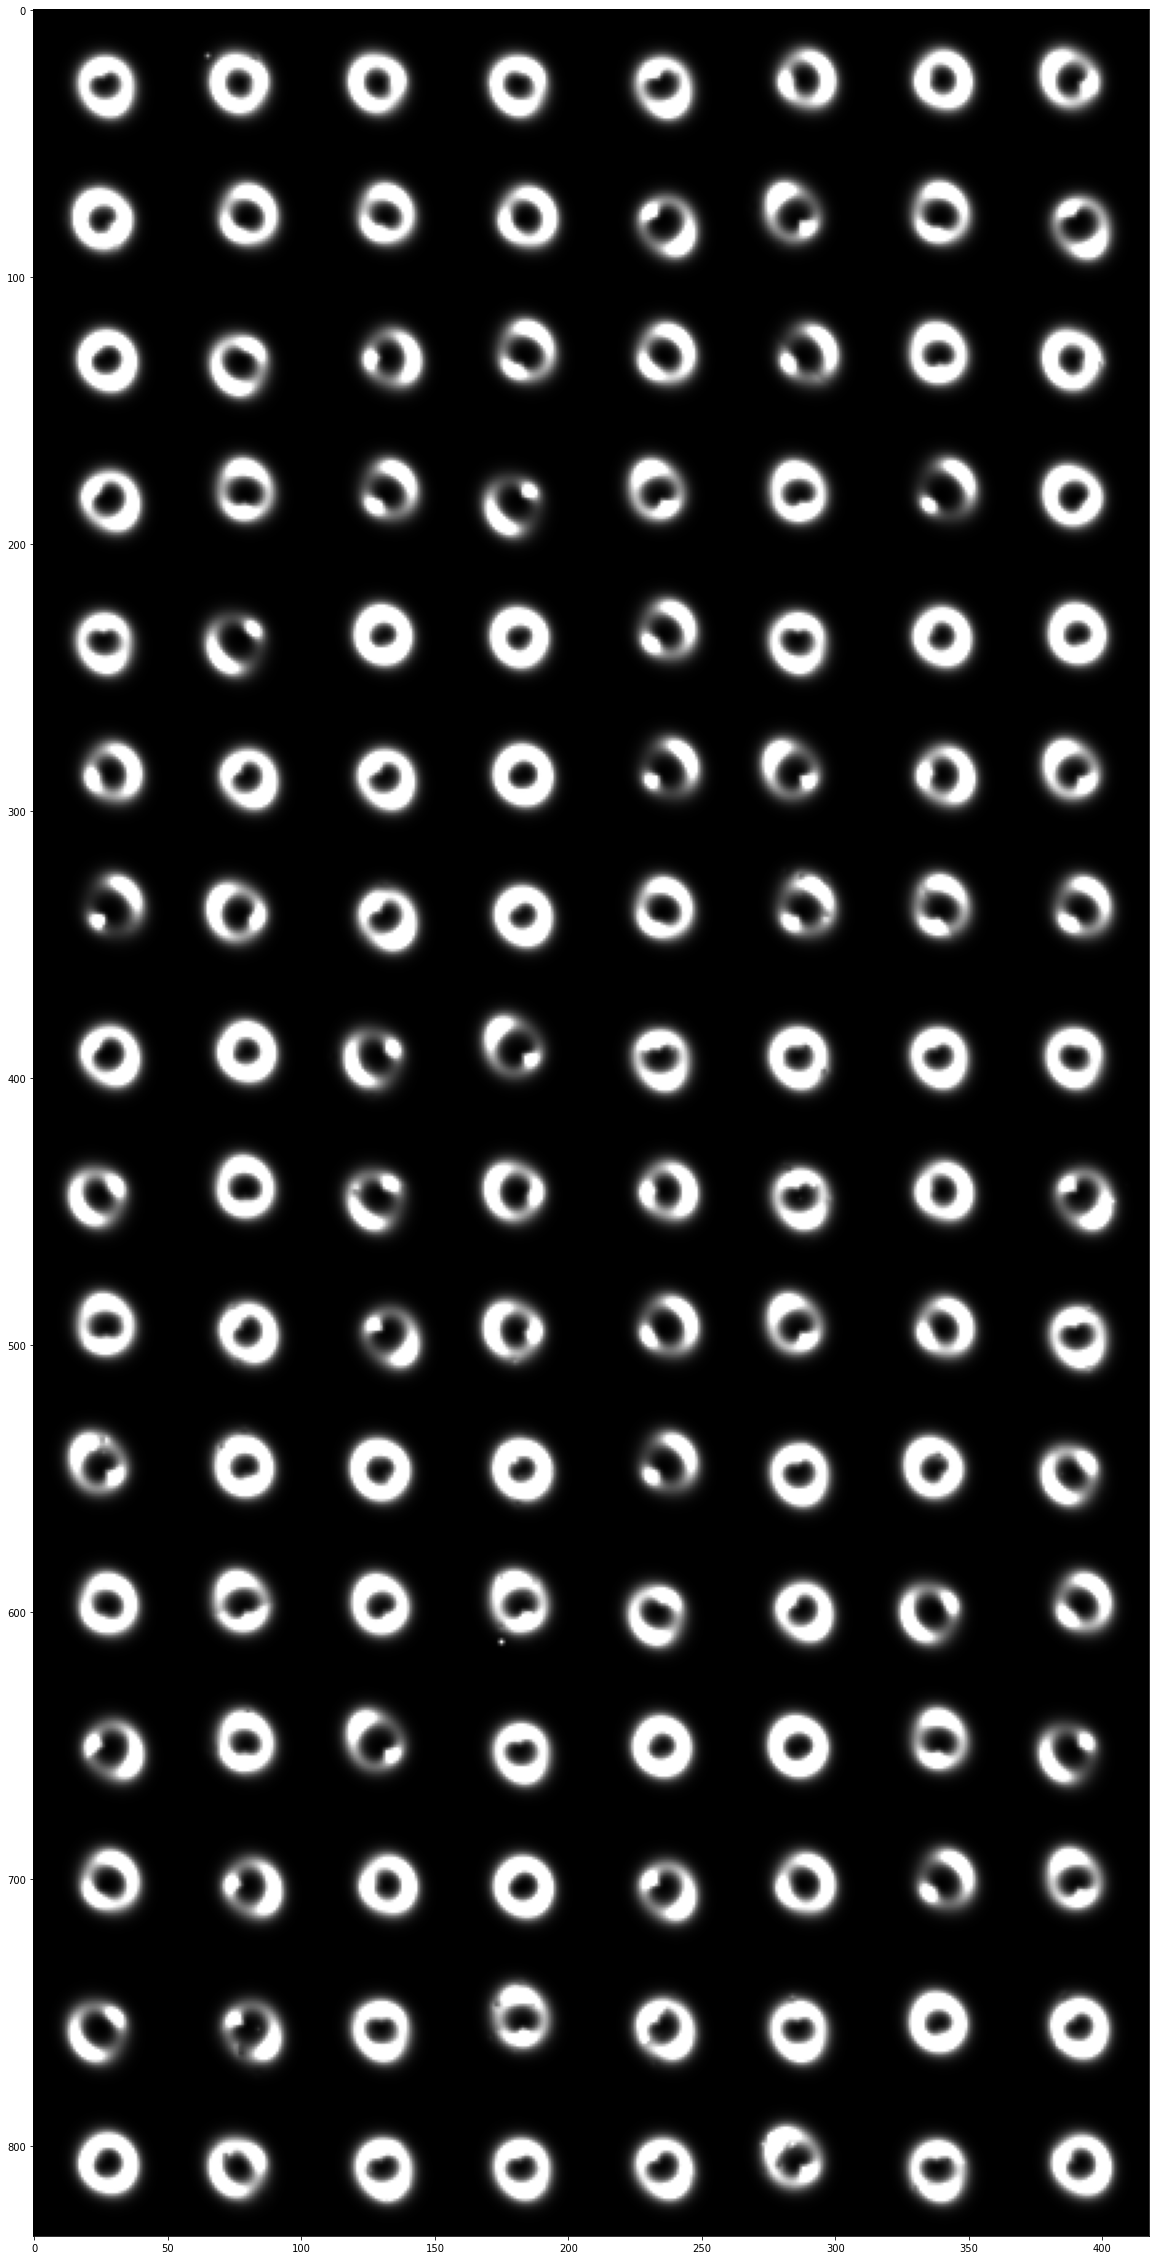

In [11]:
single_batch_grid = utils.make_grid(single_batch[0], nrow=8)
plt.figure(figsize = (20,70))
plt.imshow(single_batch_grid.permute(1, 2, 0))

In [12]:
class pre_trained_model(nn.Module):
    
    def __init__(self, pretrained = True):
        super().__init__()
        self.model = timm.create_model('efficientnet_b1',pretrained = pretrained, in_chans = 1)
#         num_in_features = self.model.get_classifier().in_features
        
        for param in self.model.parameters():
            param.requires_grad = True            
        
        self.fc = nn.Sequential(
                                nn.Linear(1280 * 2 * 2, 1024),
                                nn.PReLU(),
                                nn.BatchNorm1d(1024),
                                nn.Dropout(p = 0.5),
                                
                                nn.Linear(1024, 512),
                                nn.BatchNorm1d(512),
                                nn.PReLU(),
                                nn.Dropout(p = 0.5),
        
                                nn.Linear(512, 128),
                                nn.PReLU(),
                                nn.BatchNorm1d(128),
                                nn.Dropout(p = 0.3),
                                
                                nn.Linear(128, 3)
                                )
        
    def forward(self, x):
        x = self.model.forward_features(x)
        x = x.view(-1, 1280 * 2 * 2)
        x = self.fc(x)
        return x

In [13]:
model = pre_trained_model()

x = torch.randn(64, 1, 50, 50)
print(model(x).shape)

del model
gc.collect()

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b1-533bc792.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b1-533bc792.pth


torch.Size([64, 3])


8

In [14]:
def calculate_accuracy(y_pred, y_truth):
    y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
    _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
    
    correct_preds = (y_pred_labels == y_truth).float()
    acc = correct_preds.sum() / len(correct_preds)
    acc = torch.round(acc*100)
    
    return acc  

In [15]:
def train_epoch(model, dataloader, criterion, optimizer):
    model.train()
    train_loss = []
    train_accuracy = []

    loop=tqdm(enumerate(dataloader),total = len(dataloader))

    for batch_idx, (img_batch,labels) in loop:

        X = img_batch.to(device)
        y_truth = labels.to(device)
        
        #forward prop
        y_pred = model(X)
        
        #loss and accuracy calculation
        loss = criterion(y_pred, y_truth)
        accuracy = calculate_accuracy(y_pred, y_truth)
        
        #backprop
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        #batch loss and accuracy
        # print(f'Partial train loss: {loss.data}')
        train_loss.append(loss.detach().cpu().numpy())
        train_accuracy.append(accuracy.detach().cpu().numpy())

    return model, np.mean(train_loss), np.mean(train_accuracy)

In [16]:
def val_epoch(model, dataloader,criterion):
    model.eval()
    val_loss = []
    val_accuracy = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)

            #forward prop
            y_pred = model(X)

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            val_loss.append(loss.detach().cpu().numpy())
            val_accuracy.append(accuracy.detach().cpu().numpy())
            
    return np.mean(val_loss), np.mean(val_accuracy)

In [17]:
def fit_model(model,criterion,optimizer):
    loss_dict = {'train_loss':[],'val_loss':[]}
    acc_dict = {'train_accuracy':[],'val_accuracy':[]}
    
    scheduler = CosineAnnealingWarmRestarts(optimizer,T_0 = 15, T_mult = 1,eta_min = 1e-6, verbose=True)
    
#     scheduler = ReduceLROnPlateau(optimizer, 'min',patience=2,factor=0.3,verbose=True)


    for epoch in range(EPOCHS):
        print(f"Epoch {epoch+1}/{EPOCHS}:")
        model, train_loss, train_accuracy = train_epoch(model, train_loader, criterion, optimizer)
        val_loss, val_accuracy = val_epoch(model, val_loader, criterion)
        scheduler.step()

        print(f'Train loss:{train_loss}, Val loss:{val_loss}')
        loss_dict['train_loss'].append(train_loss)
        loss_dict['val_loss'].append(val_loss)
        print(f'Train accuracy: {train_accuracy}, Val accuracy:{val_accuracy}')
        acc_dict['train_accuracy'].append(train_accuracy)
        acc_dict['val_accuracy'].append(val_accuracy)


    return model, loss_dict, acc_dict

In [18]:
model = pre_trained_model().to(device)

criterion = nn.CrossEntropyLoss()
EPOCHS = 25
LR = 3e-4

optimizer = optim.Adam(model.parameters(),lr=LR)

In [19]:
model, loss_dict, acc_dict = fit_model(model,criterion,optimizer)

Epoch 00000: adjusting learning rate of group 0 to 3.0000e-04.
Epoch 1/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00001: adjusting learning rate of group 0 to 2.9673e-04.
Train loss:0.2685876786708832, Val loss:0.10442748665809631
Train accuracy: 89.8819808959961, Val accuracy:96.5
Epoch 2/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00002: adjusting learning rate of group 0 to 2.8708e-04.
Train loss:0.08790430426597595, Val loss:0.08068325370550156
Train accuracy: 97.07974243164062, Val accuracy:97.11428833007812
Epoch 3/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00003: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.055965010076761246, Val loss:0.06849464774131775
Train accuracy: 98.0526351928711, Val accuracy:97.72856903076172
Epoch 4/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00004: adjusting learning rate of group 0 to 2.5054e-04.
Train loss:0.038657691329717636, Val loss:0.6032839417457581
Train accuracy: 98.66666412353516, Val accuracy:77.4000015258789
Epoch 5/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00005: adjusting learning rate of group 0 to 2.2525e-04.
Train loss:0.03176412731409073, Val loss:0.520554780960083
Train accuracy: 98.88038635253906, Val accuracy:83.22856903076172
Epoch 6/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00006: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.02339998260140419, Val loss:0.05159798637032509
Train accuracy: 99.14035034179688, Val accuracy:98.42857360839844
Epoch 7/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00007: adjusting learning rate of group 0 to 1.6613e-04.
Train loss:0.0205359049141407, Val loss:0.05262850224971771
Train accuracy: 99.22168731689453, Val accuracy:98.04285430908203
Epoch 8/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00008: adjusting learning rate of group 0 to 1.3487e-04.
Train loss:0.013851379975676537, Val loss:0.03342311084270477
Train accuracy: 99.48963165283203, Val accuracy:98.94285583496094
Epoch 9/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00009: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.01231821533292532, Val loss:0.02203046716749668
Train accuracy: 99.5071792602539, Val accuracy:99.30000305175781
Epoch 10/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00010: adjusting learning rate of group 0 to 7.5750e-05.
Train loss:0.00742613198235631, Val loss:0.03033008985221386
Train accuracy: 99.69377899169922, Val accuracy:98.94285583496094
Epoch 11/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00011: adjusting learning rate of group 0 to 5.0465e-05.
Train loss:0.004737343639135361, Val loss:0.01491327304393053
Train accuracy: 99.81658935546875, Val accuracy:99.55714416503906
Epoch 12/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00012: adjusting learning rate of group 0 to 2.9552e-05.
Train loss:0.0028442598413676023, Val loss:0.01545226201415062
Train accuracy: 99.89473724365234, Val accuracy:99.52857208251953
Epoch 13/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00013: adjusting learning rate of group 0 to 1.3925e-05.
Train loss:0.0012067476054653525, Val loss:0.014201912097632885
Train accuracy: 99.9553451538086, Val accuracy:99.54285430908203
Epoch 14/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00014: adjusting learning rate of group 0 to 4.2669e-06.
Train loss:0.0006412076763808727, Val loss:0.01373731717467308
Train accuracy: 99.98245239257812, Val accuracy:99.69999694824219
Epoch 15/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00015: adjusting learning rate of group 0 to 3.0000e-04.
Train loss:0.0003955485299229622, Val loss:0.013627994805574417
Train accuracy: 99.98724365234375, Val accuracy:99.61428833007812
Epoch 16/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00016: adjusting learning rate of group 0 to 2.9673e-04.
Train loss:0.0522792749106884, Val loss:0.4741935729980469
Train accuracy: 98.31100463867188, Val accuracy:79.07142639160156
Epoch 17/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00017: adjusting learning rate of group 0 to 2.8708e-04.
Train loss:0.019794385880231857, Val loss:0.42330291867256165
Train accuracy: 99.2488021850586, Val accuracy:85.18571472167969
Epoch 18/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00018: adjusting learning rate of group 0 to 2.7145e-04.
Train loss:0.014726144261658192, Val loss:0.055339712649583817
Train accuracy: 99.44497680664062, Val accuracy:98.19999694824219
Epoch 19/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00019: adjusting learning rate of group 0 to 2.5054e-04.
Train loss:0.01122826524078846, Val loss:0.031522125005722046
Train accuracy: 99.55980682373047, Val accuracy:99.14286041259766
Epoch 20/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00020: adjusting learning rate of group 0 to 2.2525e-04.
Train loss:0.007610579486936331, Val loss:3.436539649963379
Train accuracy: 99.69696807861328, Val accuracy:62.099998474121094
Epoch 21/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00021: adjusting learning rate of group 0 to 1.9670e-04.
Train loss:0.008196920156478882, Val loss:0.042161621153354645
Train accuracy: 99.69218444824219, Val accuracy:98.94285583496094
Epoch 22/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00022: adjusting learning rate of group 0 to 1.6613e-04.
Train loss:0.005316886585205793, Val loss:0.038658130913972855
Train accuracy: 99.78947448730469, Val accuracy:99.02857208251953
Epoch 23/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00023: adjusting learning rate of group 0 to 1.3487e-04.
Train loss:0.00431390106678009, Val loss:0.016666855663061142
Train accuracy: 99.84689331054688, Val accuracy:99.57142639160156
Epoch 24/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00024: adjusting learning rate of group 0 to 1.0430e-04.
Train loss:0.0031158835627138615, Val loss:0.02909814938902855
Train accuracy: 99.8740005493164, Val accuracy:98.94285583496094
Epoch 25/25:


  0%|          | 0/627 [00:00<?, ?it/s]

  0%|          | 0/70 [00:00<?, ?it/s]

Epoch 00025: adjusting learning rate of group 0 to 7.5750e-05.
Train loss:0.0022252968046814203, Val loss:0.027271226048469543
Train accuracy: 99.91866302490234, Val accuracy:99.04285430908203


In [20]:
PATH = "effnetB2_centercrop.pth"
torch.save(model.state_dict(), PATH)

In [21]:
del model
gc.collect()

model = pre_trained_model().to(device)
model.load_state_dict(torch.load(PATH))

<All keys matched successfully>

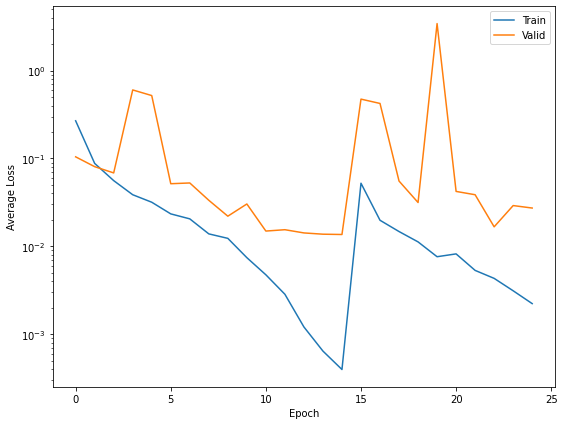

In [22]:
# # Plot losses
plt.figure(figsize=(9,7))
plt.semilogy(loss_dict['train_loss'], label='Train')
plt.semilogy(loss_dict['val_loss'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

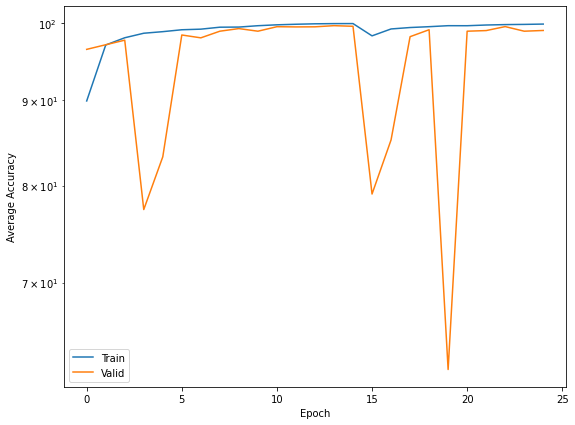

In [23]:
# Plot accuracy
plt.figure(figsize=(9,7))
plt.semilogy(acc_dict['train_accuracy'], label='Train')
plt.semilogy(acc_dict['val_accuracy'], label='Valid')
plt.xlabel('Epoch')
plt.ylabel('Average Accuracy')
#plt.grid()
plt.legend()
#plt.title('loss')
plt.show()

In [24]:
def test_epoch(model, dataloader,criterion):

    model.eval()
    test_loss = []
    test_accuracy = []
    
    y_pred_list = []
    y_pred_prob_list = []
    y_truth_list = []

    with torch.no_grad():

        loop=tqdm(enumerate(dataloader),total=len(dataloader))
        
        for batch_idx, (img_batch,labels) in loop:
            X = img_batch.to(device)
            y_truth = labels.to(device)
            y_truth_list.append(y_truth.detach().cpu().numpy())

            #forward prop
            y_pred = model(X)
            y_pred_softmax = torch.log_softmax(y_pred, dim = 1)
            y_pred_prob_list.append(torch.softmax(y_pred, dim = 1).detach().cpu().numpy())
            _, y_pred_labels = torch.max(y_pred_softmax, dim = 1)
            y_pred_list.append(y_pred_labels.detach().cpu().numpy())

            #loss and accuracy calculation
            loss = criterion(y_pred, y_truth)
            accuracy = calculate_accuracy(y_pred, y_truth)


            #batch loss and accuracy
            # print(f'Partial train loss: {loss.data}')
            test_loss.append(loss.detach().cpu().numpy())
            test_accuracy.append(accuracy.detach().cpu().numpy())
            
    return y_pred_prob_list, y_pred_list, y_truth_list, np.mean(test_loss), np.mean(test_accuracy)

In [25]:
y_pred_prob_list, y_pred_list, y_truth_list, test_loss, test_accuracy = test_epoch(model, test_loader, criterion)

print(test_loss, test_accuracy)

  0%|          | 0/118 [00:00<?, ?it/s]

0.030207857 99.23729


In [26]:
def flatten_list(x):
    flattened_list = []
    for i in x:
        for j in i:
            flattened_list.append(j)
            
    return flattened_list

In [27]:
y_pred_list_flattened = flatten_list(y_pred_list)
y_truth_list_flattened = flatten_list(y_truth_list)
y_pred_prob_list_flattened = flatten_list(y_pred_prob_list)

In [28]:
idx2class = {v: k for k, v in dataset.class_map.items()}
class_names = [i for i in dataset.class_map.keys()]
idx2class

{0: 'axion', 1: 'no_sub', 2: 'cdm'}

In [29]:
print(classification_report(y_truth_list_flattened, y_pred_list_flattened,target_names = class_names))

              precision    recall  f1-score   support

       axion       1.00      0.98      0.99      5000
      no_sub       1.00      1.00      1.00      5000
         cdm       0.98      1.00      0.99      5000

    accuracy                           0.99     15000
   macro avg       0.99      0.99      0.99     15000
weighted avg       0.99      0.99      0.99     15000



In [30]:
print(confusion_matrix(y_pred_list_flattened, y_truth_list_flattened))

[[4906    0    0]
 [   0 4987    0]
 [  94   13 5000]]


<AxesSubplot:>

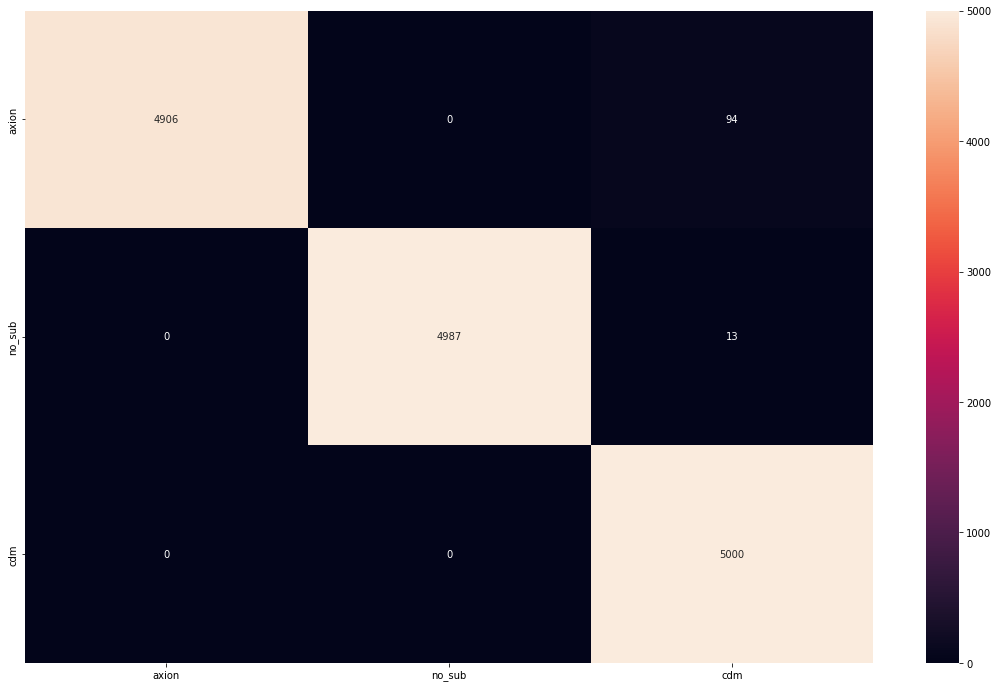

In [31]:
confusion_matrix_df = pd.DataFrame(confusion_matrix(y_truth_list_flattened, y_pred_list_flattened)).rename(columns=idx2class, index=idx2class)
fig, ax = plt.subplots(figsize=(19,12))         
sns.heatmap(confusion_matrix_df, fmt = ".0f", annot=True, ax=ax)

In [32]:
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='macro', multi_class="ovo"))
print()
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovr"))
print(roc_auc_score(y_truth_list_flattened, y_pred_prob_list_flattened, average='weighted', multi_class="ovo"))

0.9998579966666666
0.9998579966666666

0.9998579966666665
0.9998579966666667


In [33]:
fpr = {}
tpr = {}
roc_auc = {}
thresh ={}

n_class = 3

for i in range(n_class):    
    fpr[i], tpr[i], thresh[i] = roc_curve(np.array(y_truth_list_flattened), np.array(y_pred_prob_list_flattened)[:,i], pos_label=i)
    roc_auc[i] = auc(fpr[i], tpr[i])

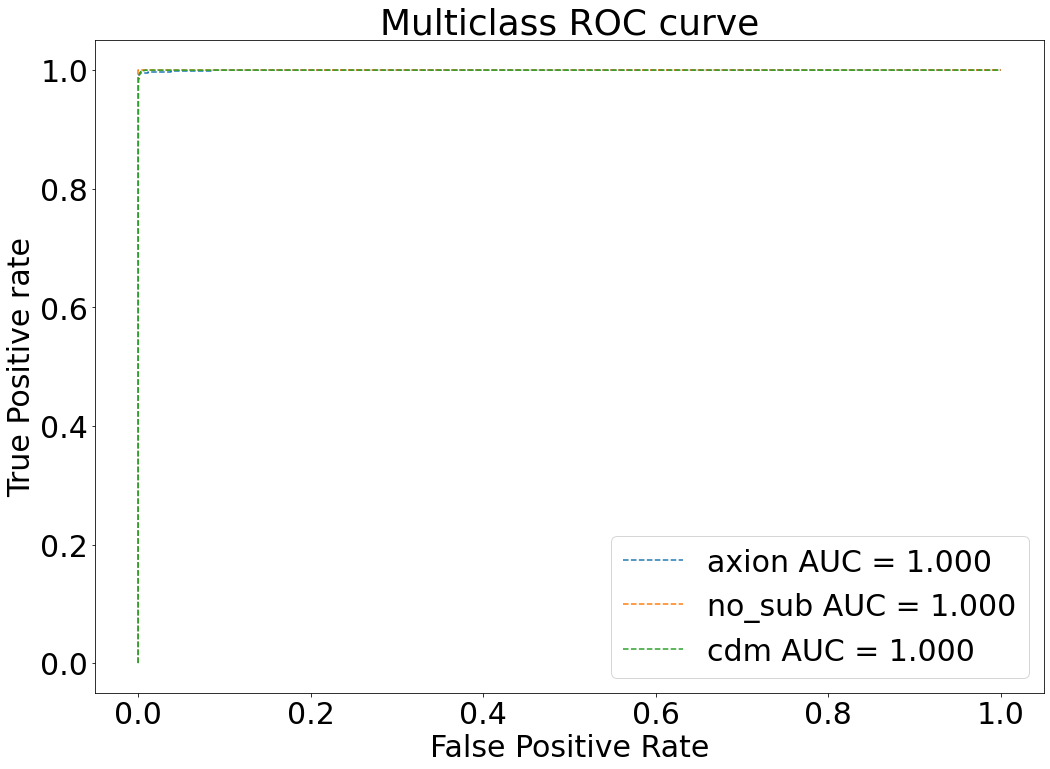

In [34]:
plt.figure(figsize=(17,12))
plt.rcParams['font.size'] = '30'
for i in range(0,n_class):
    plt.plot(fpr[i], tpr[i], linestyle='--', label=f'{idx2class[i]} AUC = {roc_auc[i]:.3f}')

    plt.title('Multiclass ROC curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive rate')
    plt.legend(loc='best')
    
plt.savefig('ROC_curves.png',dpi=352); 